
# Sentence similarity prediction model

This model uses English-English sentence pairs with similarity score data from the Semantic Evaluation competition 2017.
Data is downloaded from http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz

The model objective is to predict a similarity score between 0 and 5 given a pair of english sentences, and achieve a high pearson correlation for predicted scores and benchmark scores given in the dataset.

Model uses a pretrained Glove embedding to represent words in the sentences.
Several configurations of the 3-layered model is tested and results for 4 configurations are attached below.

The first layer is a non-trainable embedding layer loaded with pretrained glove vectors of 50 and 300 dimension.

This is followed by a middle LSTM, Bidirectional LSTM or stacked Bidirectional LSTM layer of different output dimensions 

The output layer computes a (normalised) dot product of the 2 output vectors from the middle layer for the sentence pair to yield a predicted score. As this predicted score is between 0 and 1, the 0-5 benchmark scores were normalised for comparison and cost/loss function computation.

Two loss functions were used: (1) minimizing mean square errors and (2) maximizing pearson correlation.

Some observations:
- Birectional LSTM appears to be more quicker (ie after less epochs) at reaching best results
- Little increase in train time when glove vectors of 300 dimensions are used instead of 50, 30% more train time instead of 6x
- 2 stacked LSTM did not better results of one LSTM
- best pearson correlation obtained among all configurations of this simple model is 0.67,
  substantially below competition best of 0.85, 
  which used significant text preprocessing to obtain more word/sentence features
  before feeding into an SVM regression model

Results:
                                                    
    1. Glove embedding 50d  -> shared LSTM(256)   -> dot                :   314,368 param : 0.64 p_corr, 0.95 mae
    2. Glove embedding 50d  -> shared BiLSTM(256) -> dot                :   628,736 param : 0.65 p_corr, 1.00 mae
    3. Glove embedding 300d -> shared BiLSTM(128) -> dot                :   439,296 param : 0.67 p_corr, 0.85 mae
    4. Glove embedding 300d -> shared BiLSTM(128) -> BiLSTM(128) -> dot :   833,536 param : 0.66 p_corr, 0.90 mae
    5. Glove embedding 300d -> shared BiLSTM(256) -> dot                : 1,140,736 param : 0.70 p_corr, 0.85 mae
    6. Glove embedding 300d -> shared BiLSTM(600) -> dot                : 4,324,800 param : 0.69 p_corr, 0.90 mae


Results from Microsoft downloaded Sent2Vec model:

    pc	0.736214094
    me	0.092619883
    mae	0.793664642


# Imports and Inits

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import collections
import re
import random
import numpy as np

# from nltk.tokenize import sent_tokenize, word_tokenize
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Dropout, Input, Embedding, Bidirectional, Activation
from keras.optimizers import RMSprop, Adam
from keras import backend as K

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import tensorflow as tf


Using TensorFlow backend.


In [2]:
N_SEQ = 58
N_VOCAB = 20000
EMBED_DIM = 300
N_DUMMY_VOCAB = 20

unk_vec = np.zeros(EMBED_DIM)

In [3]:
fname_sts_trn = './data/sts_source/sts-train.txt'
fname_sts_val = './data/sts_source/sts-dev.txt'
fname_sts_tes = './data/sts_source/sts-test.txt'

fname_glove = './data/glove/glove.6B.'+str(EMBED_DIM)+'d.txt'
fname_model = 'RNN_STS'
print(fname_glove)

./data/glove/glove.6B.300d.txt


# Data and embedding source

Please download dataset and place file in ./data/sts_source/ directory from this link:
'http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz'

Description of dataset is found here :
http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark

Please download pretrained glove embedding and place file in ./data/glove/ from this link:
'http://nlp.stanford.edu/data/glove.6B.zip'

# Read in sentence pair and score from STS data set


In [4]:
def read_sts(fname):

    f = open(fname, 'r', encoding='utf-8')

    i = 0
    scores = []
    sentences1 = []
    sentences2 = []
    while True:
        l = f.readline()  # read 1 line
        if not l:
            break

        data_fields = l.split("\t")
        scores.append(float(data_fields[4]))
        sentences1.append(data_fields[5])
        sentences2.append(data_fields[6])
        i = i + 1
    
        
    f.close()
    print(fname,"records count:",i)

    return i, scores, sentences1, sentences2

# read data files and obtain lists of sentences
n_trn, scores_trn, sentences1_trn, sentences2_trn = read_sts(fname_sts_trn)
n_val, scores_val, sentences1_val, sentences2_val = read_sts(fname_sts_val)
n_tes, scores_tes, sentences1_tes, sentences2_tes = read_sts(fname_sts_tes)
print("Total data samples:",n_trn+n_val+n_tes)

./data/sts_source/sts-train.txt records count: 5749
./data/sts_source/sts-dev.txt records count: 1500
./data/sts_source/sts-test.txt records count: 1379
Total data samples: 8628


# Check through dataset



In [5]:
# Visually check data set by printing one random sample from each of trn, val, tes

n = int(random.uniform(0,1)*n_trn)
print("Train Sample", n, "with similarity score", scores_trn[n])
print("1 :", sentences1_trn[n])
print("2 :", sentences2_trn[n])

n = int(random.uniform(0,1)*n_val)
print("Validation Sample", n, "with similarity score", scores_val[n])
print("1 :", sentences1_val[n])
print("2 :", sentences2_val[n])

n = int(random.uniform(0,1)*n_tes)
print("Test Sample", n, "with similarity score", scores_tes[n])
print("1 :", sentences1_tes[n])
print("2 :", sentences2_tes[n])

Train Sample 945 with similarity score 3.4
1 : the soccer player kicked the ball side to side between his legs.
2 : A person is kicking a soccer ball back and forth between his feet.

Validation Sample 1133 with similarity score 3.6
1 : U.S. District Judge Edmund Sargus ruled that the Akron-based company should have determined that changes at one of its plants would increase overall pollution emissions.
2 : FirstEnergy Corp. should have determined that modernizing one of its plants would increase overall pollution emissions, U.S. District Judge Edmund Sargus ruled Thursday.

Test Sample 49 with similarity score 1.75
1 : The ballerina is dancing.
2 : A man is dancing.



In [6]:
# compile certain stats of dataset : max_sentence_len, n_char, n_words, n_vocab

scores_all = scores_trn + scores_val + scores_tes
n_data = len(scores_all)

sent1_all = sentences1_trn + sentences1_val + sentences1_tes
sent2_all = sentences2_trn + sentences2_val + sentences2_tes

sent_all = sent1_all + sent2_all
n_sent = len(sent_all)

Sentence word length distribution:
min 2, max 58, mean 10.34, std 5.58
Shortest sentence: 9224  --  Kangaroo eating.



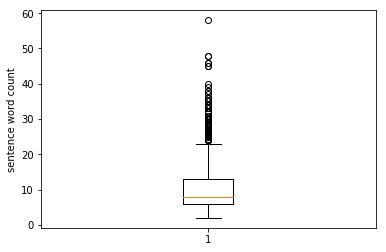

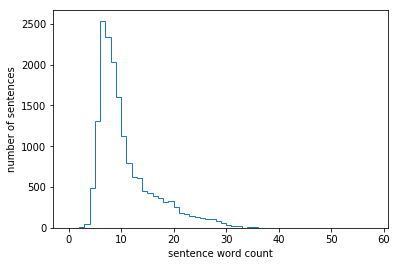

Total number of samples           n_data: 8628
Total number of sentences         n_sent: 17256    ( 2 x 8628 = 17256 )
Max words in one sentence  max_sent_wlen: 58
Max char in one sentence   max_sent_clen: 368
Total number of words            n_words: 178498
Total number of vocabulary       n_vocab: 15348
Total number of characters        n_char: 1010798


In [7]:
# Summarize sentence lengths

max_sent_clen = max(len(s) for s in sent_all)
n_char = sum(len(s) for s in sent_all)

# build keras dictionary
Ktokenizer = Tokenizer(num_words=N_VOCAB)
Ktokenizer.fit_on_texts(sent_all) 
dict_K = Ktokenizer.word_index
n_vocab = len(dict_K)

# tokenize sentences and convert words to integers for inputs
x_all = Ktokenizer.texts_to_sequences(sent_all)

slens = [len(x) for x in x_all] 
n_words = sum(slens)
max_sent_wlen = max(slens)
min_sent_wlen = min(slens)

print("Sentence word length distribution:")
print("min %d, max %d, mean %.2f, std %.2f" % (np.min(slens), np.max(slens), np.mean(slens), np.std(slens)))
n = slens.index(min_sent_wlen)
print("Shortest sentence:", n, " -- ", sent_all[n])
plt.boxplot(slens)     # boxplot to show distribution of sentence length
plt.ylabel('sentence word count')
plt.show()
plt.hist(slens, bins=max_sent_wlen, range=[0, max_sent_wlen], histtype='step')
plt.ylabel('number of sentences')
plt.xlabel('sentence word count')
plt.show()

print("Total number of samples           n_data:", n_data)
print("Total number of sentences         n_sent:", n_sent, "   ( 2 x", n_data,"=",2*n_data,")")
print("Max words in one sentence  max_sent_wlen:", max_sent_wlen)
print("Max char in one sentence   max_sent_clen:", max_sent_clen)
print("Total number of words            n_words:", n_words)
print("Total number of vocabulary       n_vocab:", n_vocab)
print("Total number of characters        n_char:", n_char)

In [8]:
# look at scores distribution

score_classes = collections.Counter(scores_all)
score_classes_sorted = sorted(score_classes)
n_score_classes = len(score_classes)
print(len(scores_all),"scores in",n_score_classes,"classes")
print(score_classes_sorted)
# scores cannot be quantized without modifying data; so treated as real numbers

8628 scores in 181 classes
[0.0, 0.067, 0.083, 0.1, 0.118, 0.133, 0.143, 0.167, 0.17, 0.188, 0.2, 0.231, 0.25, 0.267, 0.3, 0.308, 0.333, 0.364, 0.4, 0.417, 0.5, 0.533, 0.538, 0.583, 0.6, 0.636, 0.643, 0.667, 0.67, 0.727, 0.75, 0.778, 0.8, 0.833, 0.85, 0.889, 0.9, 0.944, 1.0, 1.1, 1.154, 1.2, 1.25, 1.273, 1.286, 1.3, 1.33, 1.333, 1.4, 1.5, 1.533, 1.53333333333333, 1.556, 1.583, 1.6, 1.643, 1.667, 1.67, 1.7, 1.714, 1.733, 1.75, 1.778, 1.8, 1.846, 1.9, 1.917, 2.0, 2.11111111111111, 2.167, 2.2, 2.25, 2.33, 2.333, 2.33333333333333, 2.375, 2.4, 2.46666666666667, 2.5, 2.533, 2.583, 2.588, 2.6, 2.615, 2.625, 2.647, 2.667, 2.67, 2.692, 2.7, 2.75, 2.769, 2.8, 2.812, 2.818, 2.83, 2.875, 2.909, 2.917, 3.0, 3.056, 3.067, 3.091, 3.1, 3.111, 3.167, 3.176, 3.182, 3.2, 3.231, 3.25, 3.273, 3.333, 3.33333333333333, 3.4, 3.417, 3.438, 3.444, 3.455, 3.5, 3.533, 3.538, 3.6, 3.615, 3.625, 3.643, 3.667, 3.67, 3.692, 3.714, 3.75, 3.765, 3.769, 3.77777777777778, 3.786, 3.8, 3.824, 3.833, 3.846, 3.857, 3.867, 3.

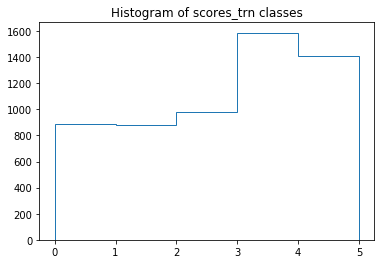

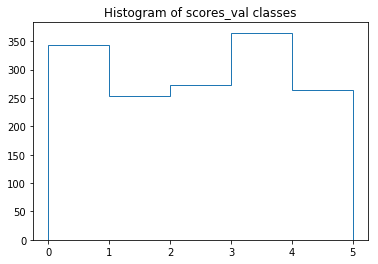

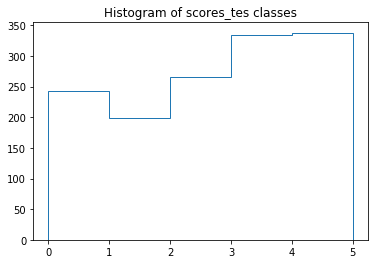

In [9]:
plt.hist(scores_trn, bins=5, range=[0, 5.0], histtype='step')
plt.title("Histogram of scores_trn classes")
plt.show()
plt.hist(scores_val, bins=5, range=[0, 5.0], histtype='step')
plt.title("Histogram of scores_val classes")
plt.show()
plt.hist(scores_tes, bins=5, range=[0, 5.0], histtype='step')
plt.title("Histogram of scores_tes classes")
plt.show()

# Load and test pre-trained GloVe embedding

In [10]:
# load the whole pre-trained embedding into memory : 400k words_glove, 100-dimension word vectors

dict_glove = dict()
f = open(fname_glove, 'r', encoding='utf-8')
print("Reading", fname_glove)
for line in f:
    values = line.split()
    w = values[0]
    wvec = np.asarray(values[1:], dtype='float64')
    dict_glove[w] = wvec

f.close()
n_glove = len(dict_glove)
print('Loaded %s word vectors.' % n_glove )


# check dictionary by printing nearest words_glove and analogous word

words_glove = list(dict_glove.keys())
wvec_glove = np.array(list(dict_glove.values()), dtype='float32')

vecn = lambda v : v / np.linalg.norm(v)
eudist = lambda u, v : np.linalg.norm(u-v)  # euclidean distance, 
                                            # no need to use this can just compare sum of squares
                                            # same result
eudist2 = lambda u, v : np.sum((u-v)*(u-v))

w2v = lambda w : dict_glove.get(w, unk_vec)

norm_glove = np.linalg.norm(wvec_glove, axis=1, keepdims=True)
wvecn_glove = wvec_glove / norm_glove

def find_nearest_eudist_word(v):
    d = [eudist2(wvec_glove[i],v) for i in range(n_glove)]
    ds = sorted(range(len(d)), key=d.__getitem__)
    return ds[0], ds[1], ds[2], ds[3], ds[4]

def find_nearest_codist_word(v):
    vn = vecn(v)
    d = [np.dot(wvecn_glove[i],vn) for i in range(n_glove)]
    ds = sorted(range(len(d)), key=d.__getitem__, reverse=True)
    return ds[0], ds[1], ds[2], ds[3], ds[4]


v = w2v("good")
r1, r2, r3, r4, r5 = find_nearest_eudist_word(v)  
print("eudist :", words_glove[r1], words_glove[r2], words_glove[r3], words_glove[r4], words_glove[r5])
r1, r2, r3, r4, r5 = find_nearest_codist_word(v)  
print("codist :", words_glove[r1], words_glove[r2], words_glove[r3], words_glove[r4], words_glove[r5])

Reading ./data/glove/glove.6B.300d.txt
Loaded 400000 word vectors.
eudist : good better well always really
codist : good better really always you


# Prepare embedding matrix and format input data 

(for use as weights in Keras embedding layer)

In [11]:
# Prepare embedding

n_vocab = min(N_VOCAB, len(dict_K)+N_DUMMY_VOCAB+1)
keras_embedding_matrix = np.zeros((n_vocab, EMBED_DIM))
print('Preparing embedding matrix of shape:', keras_embedding_matrix.shape)

for w, i in dict_K.items():
    if i >= n_vocab:    # chop of lower frequency words
        continue
    v = dict_glove.get(w)
    if v is not None:
        # words not found in embedding index will be all-zeros.
        keras_embedding_matrix[i] = v



Preparing embedding matrix of shape: (15369, 300)


In [12]:
print('Format data input')

x_all_pad = pad_sequences(x_all, maxlen=N_SEQ)
y_all = np.asarray(scores_all)
y_all = np.reshape(y_all,(y_all.shape[0],1))
print("x_all_pad:",type(x_all_pad), x_all_pad.shape)
print("y_all:",type(y_all), y_all.shape)

# Vectorize the text samples into a 2D integer tensor
x1_trn = x_all_pad[0:n_trn]
x1_val = x_all_pad[n_trn:n_trn+n_val]
x1_tes = x_all_pad[n_trn+n_val:n_data]
x2_trn = x_all_pad[n_data:n_data+n_trn]
x2_val = x_all_pad[n_data+n_trn:n_data+n_trn+n_val]
x2_tes = x_all_pad[n_data+n_trn+n_val:n_data*2]

# Normalise scores
y_all = y_all  # don't scale scores
y_trn = y_all[0:n_trn]
y_val = y_all[n_trn:n_trn+n_val]
y_tes = y_all[n_trn+n_val:n_data]

# Normalise scores
print("x1_trn:",type(x1_trn), x1_trn.shape, x1_trn.dtype)
print("x1_val:",type(x1_val), x1_val.shape, x1_val.dtype)
print("x1_tes:",type(x1_tes), x1_tes.shape, x1_tes.dtype)
print("x2_trn:",type(x2_trn), x2_trn.shape, x2_trn.dtype)
print("x2_val:",type(x2_val), x2_val.shape, x2_val.dtype)
print("x2_tes:",type(x2_tes), x2_tes.shape, x2_tes.dtype)
print("y_trn:",type(y_trn), y_trn.shape, y_trn.dtype)
print("y_val:",type(y_val), y_val.shape, y_val.dtype)
print("y_tes:",type(y_tes), y_tes.shape, y_tes.dtype)


Format data input
x_all_pad: <class 'numpy.ndarray'> (17256, 58)
y_all: <class 'numpy.ndarray'> (8628, 1)
x1_trn: <class 'numpy.ndarray'> (5749, 58) int32
x1_val: <class 'numpy.ndarray'> (1500, 58) int32
x1_tes: <class 'numpy.ndarray'> (1379, 58) int32
x2_trn: <class 'numpy.ndarray'> (5749, 58) int32
x2_val: <class 'numpy.ndarray'> (1500, 58) int32
x2_tes: <class 'numpy.ndarray'> (1379, 58) int32
y_trn: <class 'numpy.ndarray'> (5749, 1) float64
y_val: <class 'numpy.ndarray'> (1500, 1) float64
y_tes: <class 'numpy.ndarray'> (1379, 1) float64


# Build model and run

In [13]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed


BiLSTM_s = Bidirectional(LSTM(256),name='BiLSTM_s')
inp1 = Input(shape=(N_SEQ,), dtype='int32', name='Input1')
x1 = Embedding(n_vocab, EMBED_DIM, weights=[keras_embedding_matrix], 
               input_length=N_SEQ, trainable=False, name='Embedding1')(inp1)
x1 = BiLSTM_s(x1)
x1 = Dropout(0.2, name='Dropout1')(x1)

inp2 = Input(shape=(N_SEQ,), dtype='int32', name='Input2')
x2 = Embedding(n_vocab, EMBED_DIM, weights=[keras_embedding_matrix], 
               input_length=N_SEQ, trainable=False, name='Embedding2')(inp2)
x2 = BiLSTM_s(x2)
x2 = Dropout(0.2, name='Dropout2')(x2)

d = keras.layers.dot([x1, x2], axes=1, normalize=True, name='Dot')
output = Dense(1,
               activation = 'relu', 
               kernel_initializer=keras.initializers.Identity(gain=5.0),
               bias_initializer='zeros',
               trainable=False,
               name='DenseOut')(d)

In [14]:
model = keras.models.Model(inputs=[inp1, inp2], outputs=output)
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input1 (InputLayer)              (None, 58)            0                                            
____________________________________________________________________________________________________
Input2 (InputLayer)              (None, 58)            0                                            
____________________________________________________________________________________________________
Embedding1 (Embedding)           (None, 58, 300)       4610700     Input1[0][0]                     
____________________________________________________________________________________________________
Embedding2 (Embedding)           (None, 58, 300)       4610700     Input2[0][0]                     
___________________________________________________________________________________________

In [13]:
# define pearson correlation as model metric

def pearson_corr(a, b):

    a_mean = K.mean(a)
    b_mean = K.mean(b)
    a_diff = a - a_mean
    b_diff = b - b_mean

    pcorr = K.sum(a_diff*b_diff)/K.sqrt(K.sum(a_diff*a_diff))/K.sqrt(K.sum(b_diff*b_diff))
    
    return pcorr

def pearson_corr_neg(a, b):
    return -pearson_corr(a,b)

def loss_function(a, b):
    return -pearson_corr(a,b)




In [ ]:
#model.compile(loss=pearson_corr_neg, optimizer=keras.optimizers.Adadelta(), metrics=['mae'])
#model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(), metrics=['mae'])
model.compile(loss=pearson_corr_neg,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['mae'])

In [17]:
# define the checkpoint
#fname_checkpoints ="./checkpoints/weights-improvement-{epoch:02d}-{loss:.4f}-RNN-sts.hdf5"
fname_checkpoints ="./checkpoints/RNN-sts-max-pc.hdf5"
checkpoint = ModelCheckpoint(fname_checkpoints, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
#keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)


In [18]:
batch_size = 16
epochs = 40
hist = model.fit([x1_trn, x2_trn], y_trn,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks = callbacks_list,
          validation_data=([x1_val, x2_val], y_val))

Train on 5749 samples, validate on 1500 samples
Epoch 1/40
5749/5749 [==============================] - 271s - loss: -0.5586 - mean_absolute_error: 1.0039 - val_loss: -0.5397 - val_mean_absolute_error: 1.2406
Epoch 2/40
5749/5749 [==============================] - 275s - loss: -0.6925 - mean_absolute_error: 0.8442 - val_loss: -0.5746 - val_mean_absolute_error: 1.2543
Epoch 3/40
5749/5749 [==============================] - 278s - loss: -0.7533 - mean_absolute_error: 0.7684 - val_loss: -0.6166 - val_mean_absolute_error: 1.0199
Epoch 4/40
5749/5749 [==============================] - 276s - loss: -0.7966 - mean_absolute_error: 0.7139 - val_loss: -0.5860 - val_mean_absolute_error: 1.1698
Epoch 5/40
5749/5749 [==============================] - 276s - loss: -0.8216 - mean_absolute_error: 0.6756 - val_loss: -0.6294 - val_mean_absolute_error: 0.9547
Epoch 6/40
5749/5749 [==============================] - 277s - loss: -0.8420 - mean_absolute_error: 0.6439 - val_loss: -0.6444 - val_mean_absolute_

5749/5749 [==============================] - 278s - loss: -0.9587 - mean_absolute_error: 0.4902 - val_loss: -0.6630 - val_mean_absolute_error: 0.7867
Epoch 27/40
5749/5749 [==============================] - 280s - loss: -0.9565 - mean_absolute_error: 0.4977 - val_loss: -0.6526 - val_mean_absolute_error: 0.7972
Epoch 28/40
5749/5749 [==============================] - 282s - loss: -0.9605 - mean_absolute_error: 0.4966 - val_loss: -0.6432 - val_mean_absolute_error: 0.8111
Epoch 29/40
5749/5749 [==============================] - 285s - loss: -0.9611 - mean_absolute_error: 0.4996 - val_loss: -0.6599 - val_mean_absolute_error: 0.7910
Epoch 30/40
5749/5749 [==============================] - 284s - loss: -0.9621 - mean_absolute_error: 0.5017 - val_loss: -0.6531 - val_mean_absolute_error: 0.7889
Epoch 31/40
5749/5749 [==============================] - 283s - loss: -0.9632 - mean_absolute_error: 0.5029 - val_loss: -0.6783 - val_mean_absolute_error: 0.7738
Epoch 32/40
5749/5749 [=================

In [14]:
import os, time
for f in os.listdir('./models/'):
    t = time.ctime(os.path.getmtime('./models/'+f))
    s = '{:<50}'.format(f[:50])
    print(s, t)

RNN-sts-max-pc.hdf5                                Fri Nov 17 04:41:52 2017
RNN-sts.hdf5                                       Fri Nov 17 01:34:36 2017
RNN_STS3-300d-bilstm256-2.h5                       Thu Nov 16 16:32:22 2017
RNN_STS3-300d-bilstm256-scaled-max-pc.h5           Fri Nov 17 05:24:15 2017
RNN_STS3-300d-bilstm256-scaled-min-mae.h5          Fri Nov 17 02:09:28 2017
RNN_STS3-300d-bilstm256-scaled.h5                  Thu Nov 16 22:18:04 2017
RNN_STS3-300d-bilstm256.h5                         Sat Nov 11 04:24:57 2017
RNN_STS3-300d-bilstm256_dummy.h5                   Sat Nov 11 10:28:28 2017


In [ ]:
fname_model = 'RNN_STS3-300d-bilstm256-scaled2a-max-pc.h5'
model.save(fname_model)

In [20]:
fname_model = './models/RNN-sts.hdf5'
model = load_model(fname_model, custom_objects={'pearson_corr_neg': pearson_corr_neg})

In [21]:
print(hist.history.keys())

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


In [20]:
def get_history(hist,metric):
    if metric == 'loss' or metric == 'val_loss':
        return neg_list(list(hist.history[metric]))
    else:
        return list(hist.history[metric])


In [48]:
hist1_pearson_corr = get_history(hist,'val_loss')
hist1_mae = get_history(hist,'val_mean_absolute_error')

In [50]:
hist2_pearson_corr = get_history(hist,'val_loss')
hist2_mae = get_history(hist,'val_mean_absolute_error')

In [46]:
hist_pearson_corr = hist1_pearson_corr + hist2_pearson_corr
hist_mae = hist1_mae + hist2_mae

plt.plot(hist_pearson_corr,'bo-')
plt.grid(axis='both', color='c', linestyle='-', linewidth=1)
plt.title('train history pearson correlation')
plt.xlabel('epoch')
plt.ylabel('validation pearson correlation')
plt.show()

          
plt.plot(hist_mae,'bo-')
plt.grid(axis='both', color='c', linestyle='-', linewidth=1)
plt.title('train history mean absolute error')
plt.xlabel('epoch')
plt.ylabel('validation mean absolute error')
plt.show()


NameError: name 'hist1_pearson_corr' is not defined

best epochs by pc and mae : [30, 35]
Pearson correlation : 0.678318615317
Mean absolute error : 0.772139692942


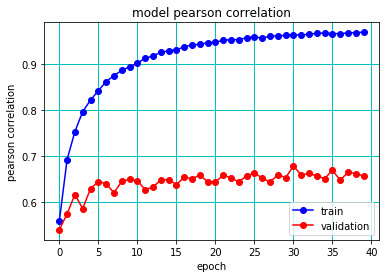

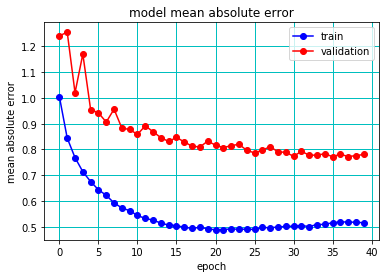

In [21]:
neg_list = lambda in_list : list(-x for x in in_list)
def plot_train(hist,metric):
    h = hist.history
    if metric=='mean_absolute_error':
        loc='upper right'
        y1 = hist.history['mean_absolute_error']
        y2 = hist.history['val_mean_absolute_error']
        ylb = 'mean absolute error'
    else:
        meas='loss'
        loc='lower right'
        y1 = neg_list(hist.history['loss'])
        y2 = neg_list(hist.history['val_loss'])
        ylb = 'pearson correlation'
    plt.plot(y1,'bo-')
    plt.plot(y2,'ro-')
    plt.grid(axis='both', color='c', linestyle='-', linewidth=1)
    plt.title('model '+ ylb)
    plt.ylabel(ylb)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    plt.show()

pc = get_history(hist,'val_loss')
mae = get_history(hist,'val_mean_absolute_error')
max_pc = max(pc)
min_mae = min(mae)
best_epochs = [i for i, x in enumerate(pc) if (x == max_pc)] + [i for i, x in enumerate(mae) if (x == min_mae)]
print("best epochs by pc and mae :", best_epochs)
print("Pearson correlation :", max_pc)
print("Mean absolute error :", min_mae)
plot_train(hist,'loss')
plot_train(hist,'mean_absolute_error')



In [16]:
# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate([x1_tes, x2_tes], y_tes)

1379/1379 [==============================] - 11s    


In [21]:
y_pred_trn = model.predict([x1_trn, x2_trn], verbose=0, steps=None)
y_pred_val = model.predict([x1_val, x2_val], verbose=0, steps=None)
y_pred_tes = model.predict([x1_tes, x2_tes], verbose=0, steps=None)

In [58]:
pred_adj = lambda pred : 5.0 * np.maximum(pred,0.0)
y_pred_trn = pred_adj(y_pred_trn)
y_pred_val = pred_adj(y_pred_val)
y_pred_tes = pred_adj(y_pred_tes)


In [18]:
print("")
print('Model pearson correlation = %.4f' % (-evaluation[0]))
print('Model mean absolute error = %.4f' % (evaluation[1]))


Model pearson correlation = 0.6817
Model mean absolute error = 0.8347


Whole dataset      : Err min -3.35, max 3.83, mean 0.13, abs err mean 0.42, pcorr 0.90
Train dataset      : Err min -1.50, max 3.30, mean 0.09, abs err mean 0.23, pcorr 0.98
Validation dataset : Err min -3.25, max 2.96, mean 0.11, abs err mean 0.75, pcorr 0.77
Test dataset       : Err min -3.35, max 3.83, mean 0.3126, abs err mean 0.8417, pcorr 0.7331

Percentage and count of prediction with errors between:
(-5.0,-4.0] :  0.00%   (0)
(-4.0,-3.0] :  0.07%   (1)
(-3.0,-2.0] :  0.73%   (10)
(-2.0,-1.0] :  8.56%   (118)
(-1.0, 0.0] :  31.54%   (435)
( 0.0, 1.0] :  34.23%   (472)
( 1.0, 2.0] :  17.91%   (247)
( 2.0, 3.0] :  6.31%   (87)
( 3.0, 4.0] :  0.65%   (9)
( 4.0, 5.0] :  0.00%   (0)

Percentage scores with 0.5 or less error : 39.09%
Percentage scores with 1.0 or less error : 65.77%
Percentage scores with 1.5 or less error : 83.68%
Percentage scores with 2.0 or less error : 92.24%
Percentage scores with 2.5 or less error : 96.95%


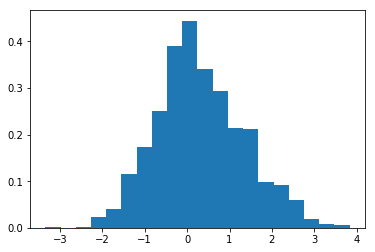

Number of samples within error threshold (2.00 - 5.00] : 96 (6.96%)

Sample 57 score 0.27 predicted score 2.53 difference 2.26
1 : A woman is cutting an onion.
2 : A woman is cleaning a garden.


Sample 101 score 0.40 predicted score 2.41 difference 2.01
1 : A woman is talking to her pet bunny as she fondles it.
2 : A woman walks her dog onto astro turf.


Sample 176 score 2.00 predicted score 4.05 difference 2.05
1 : A woman opens a window.
2 : A woman is looking out a window.


Sample 268 score 1.20 predicted score 3.33 difference 2.13
1 : A cat laying on a red cushion looking at the camera.
2 : A tan dog lying on a moggie bed looking up at the camera.


Sample 271 score 0.00 predicted score 2.32 difference 2.32
1 : A man sitting in a back yard playing the guitar.
2 : A man riding on the back of an orange SUV.


Number of samples within error threshold (-5.00 - -2.00] : 11 (0.80%)

Sample 741 score 3.00 predicted score 0.74 difference -2.26
1 : I've located an article that might be o

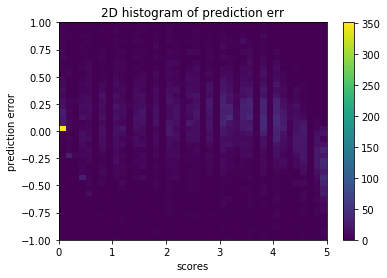

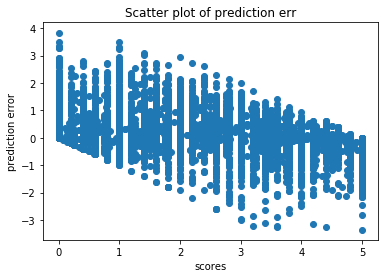

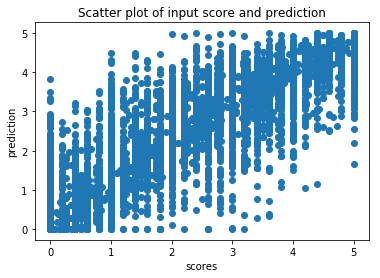

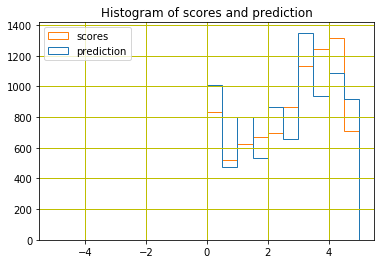

In [22]:
# ****** Box 1
def err_stats(pred, ground):
    a = np.reshape(pred,pred.shape[0])
    b = np.asarray(ground)
    b = np.reshape(b,b.shape[0])
    err = a - b
    pcorr = np.corrcoef(a, b)
    
    return err, np.min(err), np.max(err), np.mean(err), np.mean(np.abs(err)), pcorr[0][1]

#pred_adj = lambda pred : 5.0 * np.maximum(pred,0.0)
pred_adj = lambda pred : pred
y_pred_all = np.concatenate((y_pred_trn,y_pred_val,y_pred_tes))

err_all, err_min, err_max, err_mean, err_absmean, pcorr = err_stats(pred_adj(y_pred_all), scores_all)
print("Whole dataset      : Err min %0.2f, max %.2f, mean %.2f, abs err mean %.2f, pcorr %.2f" % (err_min,err_max,err_mean,err_absmean,pcorr))

err_trn, err_min, err_max, err_mean, err_absmean, pcorr = err_stats(pred_adj(y_pred_trn), scores_trn)
print("Train dataset      : Err min %0.2f, max %.2f, mean %.2f, abs err mean %.2f, pcorr %.2f" % (err_min,err_max,err_mean,err_absmean,pcorr))

err_val, err_min, err_max, err_mean, err_absmean, pcorr = err_stats(pred_adj(y_pred_val), scores_val)
print("Validation dataset : Err min %0.2f, max %.2f, mean %.2f, abs err mean %.2f, pcorr %.2f" % (err_min,err_max,err_mean,err_absmean,pcorr))

err_tes, err_min, err_max, err_mean, err_absmean, pcorr = err_stats(pred_adj(y_pred_tes), scores_tes)
print("Test dataset       : Err min %0.2f, max %.2f, mean %.4f, abs err mean %.4f, pcorr %.4f" % (err_min,err_max,err_mean,err_absmean,pcorr))



# ****** Box 2
def err_percent_within_threshold(lo, hi, err):
    err_idx = [i for i, x in enumerate(err) if (x > lo) and (x <= hi)]
    return len(err_idx)/len(err)*100
    
err = err_tes
n = n_tes
print("")
print("Percentage and count of prediction with errors between:")
err_hist = np.zeros(10)
for i in range(10):
    th_lo = i * 1.0 - 5.0
    th_hi = (i+1) * 1.0 - 5.0
    err_idx = [i for i, x in enumerate(err) if (x > th_lo) and (x <= th_hi)]
    err_hist[i] = len(err_idx)/n*100
    print("(%  .1f,%  .1f] : % .2f%%   (%d)" % (th_lo, th_hi, err_hist[i], len(err_idx)))

print("")
print("Percentage scores with 0.5 or less error : %.2f%%" %  (err_percent_within_threshold(-0.5, 0.5, err)))
print("Percentage scores with 1.0 or less error : %.2f%%" %  (err_percent_within_threshold(-1.0, 1.0, err)))
print("Percentage scores with 1.5 or less error : %.2f%%" %  (err_percent_within_threshold(-1.5, 1.5, err)))
print("Percentage scores with 2.0 or less error : %.2f%%" %  (err_percent_within_threshold(-2.0, 2.0, err)))
print("Percentage scores with 2.5 or less error : %.2f%%" %  (err_percent_within_threshold(-2.5, 2.5, err)))

plt.hist(err, normed=True, bins=20)
plt.show()



# ****** Box 3
# print samples with high errors

err = err_tes
scores = scores_tes
n = n_tes
pred = pred_adj(y_pred_tes)
sent1 = sentences1_tes
sent2 = sentences2_tes
th_lo = 2.0
th_hi = 5.0
err_idx = [i for i, x in enumerate(err) if (x > th_lo) and (x <= th_hi)]

print("Number of samples within error threshold (%.2f - %.2f] : %d (%.2f%%)\n" % (th_lo, th_hi, len(err_idx), len(err_idx)/n*100.0))
for i in range(min(5,len(err_idx))):
    n = err_idx[i]
    print("Sample %d score %.2f predicted score %.2f difference %.2f" % (n, scores[n], pred[n], err[n]))
    print("1 :", sent1[n])
    print("2 :", sent2[n])
    print("")

err = err_tes
scores = scores_tes
n = n_tes
pred = pred_adj(y_pred_tes)
sent1 = sentences1_tes
sent2 = sentences2_tes
th_lo = -5.0
th_hi = -2.0
err_idx = [i for i, x in enumerate(err) if (x > th_lo) and (x <= th_hi)]

print("Number of samples within error threshold (%.2f - %.2f] : %d (%.2f%%)\n" % (th_lo, th_hi, len(err_idx), len(err_idx)/n*100.0))
for i in range(min(5,len(err_idx))):
    n = err_idx[i]
    print("Sample %d score %.2f predicted score %.2f difference %.2f" % (n, scores[n], pred[n], err[n]))
    print("1 :", sent1[n])
    print("2 :", sent2[n])
    print("")

# ****** Box 4
s = np.asarray(scores_all)
e = np.reshape(err_all,n_data)
p = np.reshape(y_pred_all,n_data)
print(type(s),s.shape)
print(type(e),e.shape)
plt.hist2d(s,e, bins=40, range=[[0.0,5.0],[-1.0,1.0]])
plt.colorbar()
plt.title('2D histogram of prediction err')
plt.xlabel('scores')
plt.ylabel('prediction error')
plt.show()

plt.scatter(s,e)
plt.title('Scatter plot of prediction err')
plt.xlabel('scores')
plt.ylabel('prediction error')
plt.show()

plt.scatter(s,y_pred_all)
plt.title('Scatter plot of input score and prediction')
plt.xlabel('scores')
plt.ylabel('prediction')
plt.show()

combo = []
combo.append(s)
combo.append(p)
plt.grid(axis='both', color='y', linestyle='-', linewidth=1)
plt.hist(combo, bins=20, range=[-5.0, 5.0], histtype='step')
plt.title("Histogram of scores and prediction")
plt.legend(['scores', 'prediction'],loc='upper left')
plt.show()



# Results of saved models:

RNN_STS3-300d-bilstm256-scaled-max-pc.h5

    Whole dataset      : Err min -3.40, max 3.73, mean 0.15, abs err mean 0.42, pcorr 0.91
    Train dataset      : Err min -0.87, max 3.43, mean 0.10, abs err mean 0.22, pcorr 0.98
    Validation dataset : Err min -3.40, max 2.97, mean 0.17, abs err mean 0.78, pcorr 0.76
    Test dataset       : Err min -3.30, max 3.73, mean 0.35, abs err mean 0.84, pcorr 0.74

    Percentage and count of prediction with errors between:
    (-5.0,-4.0] :  0.00%   (0)
    (-4.0,-3.0] :  0.07%   (1)
    (-3.0,-2.0] :  0.58%   (8)
    (-2.0,-1.0] :  7.90%   (109)
    (-1.0, 0.0] :  32.70%   (451)
    ( 0.0, 1.0] :  32.34%   (446)
    ( 1.0, 2.0] :  19.87%   (274)
    ( 2.0, 3.0] :  5.80%   (80)
    ( 3.0, 4.0] :  0.73%   (10)
    ( 4.0, 5.0] :  0.00%   (0)

    Percentage scores with 0.5 or less error : 40.25%
    Percentage scores with 1.0 or less error : 65.05%
    Percentage scores with 1.5 or less error : 83.03%
    Percentage scores with 2.0 or less error : 92.82%
    Percentage scores with 2.5 or less error : 96.95%

    Number of samples within error threshold (2.00 - 5.00] : 90 (6.53%)

    Sample 37 score 1.20 predicted score 3.44 difference 2.24
    1 : A man is cutting a pipe with scissors.
    2 : A man is cutting carpet with a knife.


    Sample 57 score 0.27 predicted score 2.40 difference 2.13
    1 : A woman is cutting an onion.
    2 : A woman is cleaning a garden.


    Sample 101 score 0.40 predicted score 2.88 difference 2.48
    1 : A woman is talking to her pet bunny as she fondles it.
    2 : A woman walks her dog onto astro turf.


    Sample 176 score 2.00 predicted score 4.17 difference 2.17
    1 : A woman opens a window.
    2 : A woman is looking out a window.


    Sample 271 score 0.00 predicted score 2.00 difference 2.00
    1 : A man sitting in a back yard playing the guitar.
    2 : A man riding on the back of an orange SUV.


    Number of samples within error threshold (-5.00 - -2.00] : 9 (0.65%)

    Sample 649 score 4.00 predicted score 1.57 difference -2.43
    1 : This is not a good idea.
    2 : This sound like a very bad idea.

    Sample 745 score 5.00 predicted score 2.56 difference -2.44
    1 : It's also a matter of taste.
    2 : It's definitely just a matter of preference.

    Sample 810 score 5.00 predicted score 2.69 difference -2.31
    1 : I'm afraid we are out of luck in this one.
    2 : I think this is one of those things where you are just out of luck.

    Sample 835 score 4.00 predicted score 1.53 difference -2.47
    1 : I think there isn't a general answer.
    2 : I don't think there is a single definition.

    Sample 839 score 5.00 predicted score 2.90 difference -2.10
    1 : I had the same problem as you.
    2 : I have exactly the same problem.

In [37]:
print(y_pred_trn.shape,y_pred_val.shape,y_pred_tes.shape)
y_pred_all = np.concatenate((y_pred_trn,y_pred_val,y_pred_tes))
scores = np.expand_dims(np.asarray(scores_all),axis=1)
y_pred_all = y_pred_all * 5.0
err = y_pred_all - scores
err_mean = np.mean(err)
abserr_mean = np.mean(np.abs(err))
err_max = np.max(err)
err_min = np.min(err)

print(type(y_pred_all),y_pred_all.shape)
print(type(scores),scores.shape)
print(type(err),err.shape)
print(err_mean,err_min,err_max)
print(abserr_mean)


(5749, 1) (1500, 1) (1379, 1)
<class 'numpy.ndarray'> (8628, 1)
<class 'numpy.ndarray'> (8628, 1)
<class 'numpy.ndarray'> (8628, 1)
-1.35221348003 -4.27435183525 1.69325339794
1.4570834512


<class 'numpy.ndarray'> (8628,)
<class 'numpy.ndarray'> (8628,)


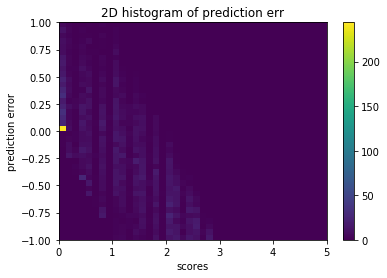

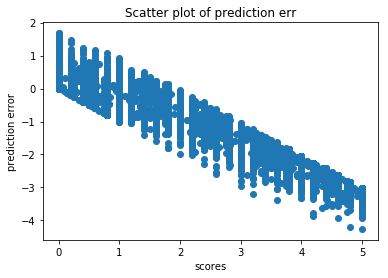

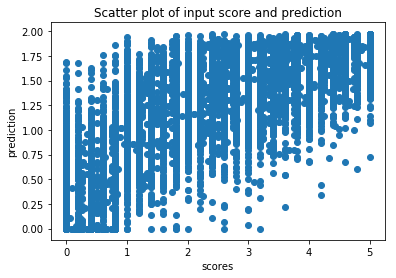

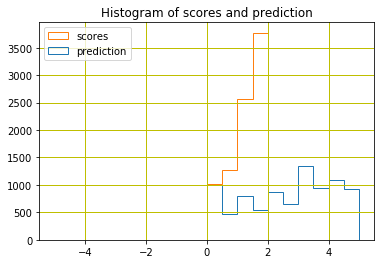

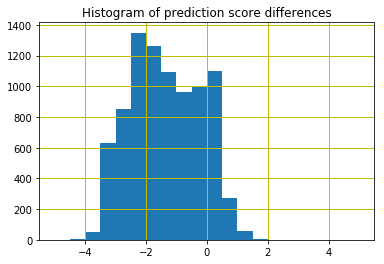

In [38]:
s = np.asarray(scores_all)
e = np.reshape(err,n_data)
p = np.reshape(y_pred_all,n_data)
print(type(s),s.shape)
print(type(e),e.shape)
plt.hist2d(s,e, bins=40, range=[[0.0,5.0],[-1.0,1.0]])
plt.colorbar()
plt.title('2D histogram of prediction err')
plt.xlabel('scores')
plt.ylabel('prediction error')
plt.show()

plt.scatter(s,e)
plt.title('Scatter plot of prediction err')
plt.xlabel('scores')
plt.ylabel('prediction error')
plt.show()

plt.scatter(s,y_pred_all)
plt.title('Scatter plot of input score and prediction')
plt.xlabel('scores')
plt.ylabel('prediction')
plt.show()

combo = []
combo.append(s)
combo.append(p)
plt.grid(axis='both', color='y', linestyle='-', linewidth=1)
plt.hist(combo, bins=20, range=[-5.0, 5.0], histtype='step')
plt.title("Histogram of scores and prediction")
plt.legend(['scores', 'prediction'],loc='upper left')
plt.show()

plt.grid(axis='both', color='y', linestyle='-', linewidth=1)
plt.hist(err, bins=20, range=[-5.0, 5.0], histtype='stepfilled')
plt.title("Histogram of prediction score differences")
plt.show()

Percentage of prediction >= 0.5 above benchmark scores : 3.84%
Percentage of prediction >= 0.5 below benchmark scores :  71.96%


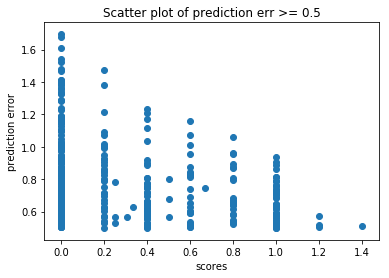

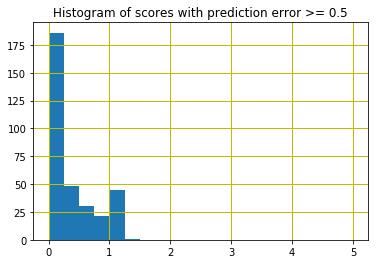

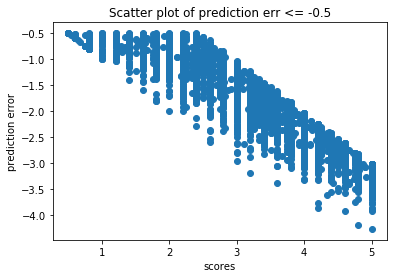

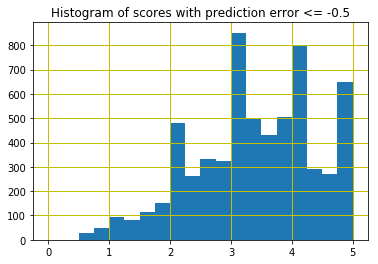

In [39]:
# examine errors >= 0.5 or <= -0.5

err_idx_hi = [i for i, x in enumerate(err) if x >= 0.5]
err_idx_lo = [i for i, x in enumerate(err) if x <= -0.5]
print("Percentage of prediction >= 0.5 above benchmark scores : %.2f%%" % (len(err_idx_hi)/n_data*100))
print("Percentage of prediction >= 0.5 below benchmark scores : % .2f%%" % (len(err_idx_lo)/n_data*100))

plt.scatter(s[err_idx_hi],e[err_idx_hi])
plt.title('Scatter plot of prediction err >= 0.5')
plt.xlabel('scores')
plt.ylabel('prediction error')
plt.show()

plt.grid(axis='both', color='y', linestyle='-', linewidth=1)
plt.hist(s[err_idx_hi], bins=20, range=[0, 5.0], histtype='stepfilled')
plt.title("Histogram of scores with prediction error >= 0.5")
plt.show()

plt.scatter(s[err_idx_lo],e[err_idx_lo])
plt.title('Scatter plot of prediction err <= -0.5')
plt.xlabel('scores')
plt.ylabel('prediction error')
plt.show()

plt.grid(axis='both', color='y', linestyle='-', linewidth=1)
plt.hist(s[err_idx_lo], bins=20, range=[0, 5.0], histtype='stepfilled')
plt.title("Histogram of scores with prediction error <= -0.5")
plt.show()


Percentage of prediction >= 1.0 above benchmark scores : 0.70%
Percentage of prediction >= 1.0 below benchmark scores :  60.74%


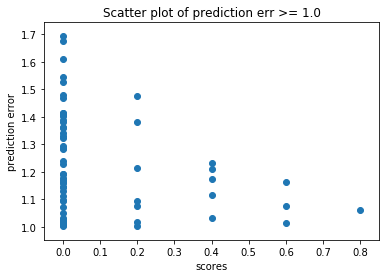

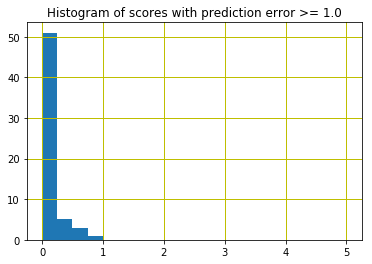

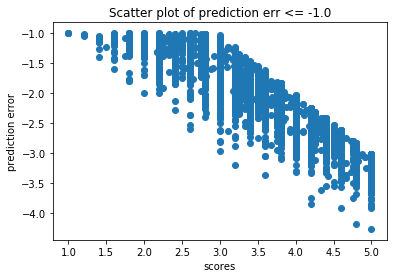

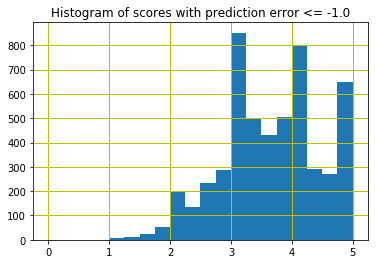

In [40]:
# examine errors >= 1 or <= -1

err_idx_hi = [i for i, x in enumerate(err) if x >= 1.0]
err_idx_lo = [i for i, x in enumerate(err) if x <= -1.0]
print("Percentage of prediction >= 1.0 above benchmark scores : %.2f%%" % (len(err_idx_hi)/n_data*100))
print("Percentage of prediction >= 1.0 below benchmark scores : % .2f%%" % (len(err_idx_lo)/n_data*100))

plt.scatter(s[err_idx_hi],e[err_idx_hi])
plt.title('Scatter plot of prediction err >= 1.0')
plt.xlabel('scores')
plt.ylabel('prediction error')
plt.show()

plt.grid(axis='both', color='y', linestyle='-', linewidth=1)
plt.hist(s[err_idx_hi], bins=20, range=[0, 5.0], histtype='stepfilled')
plt.title("Histogram of scores with prediction error >= 1.0")
plt.show()

plt.scatter(s[err_idx_lo],e[err_idx_lo])
plt.title('Scatter plot of prediction err <= -1.0')
plt.xlabel('scores')
plt.ylabel('prediction error')
plt.show()

plt.grid(axis='both', color='y', linestyle='-', linewidth=1)
plt.hist(s[err_idx_lo], bins=20, range=[0, 5.0], histtype='stepfilled')
plt.title("Histogram of scores with prediction error <= -1.0")
plt.show()


## Observation : low scores are too high and high scores are too low !!!

In [23]:
print(len(dict_K))
print(n_vocab)
print(max([np.max(x) for x in x2_tes] ))
print(model.layers)


lay=model.get_layer(name='Embedding1')
lw=lay.get_weights()
print(lay.input)
print(lay.output)
print(lay.get_config)
print(lw[0].shape)
print(keras_embedding_matrix.shape)


15348
15349
15348
[<keras.engine.topology.InputLayer object at 0x00000251F12824A8>, <keras.engine.topology.InputLayer object at 0x00000251F1282518>, <keras.layers.embeddings.Embedding object at 0x00000251F1282710>, <keras.layers.embeddings.Embedding object at 0x00000251F1282588>, <keras.layers.wrappers.Bidirectional object at 0x00000251F062DEB8>, <keras.layers.core.Dropout object at 0x00000251F1282048>, <keras.layers.core.Dropout object at 0x00000251F1282860>, <keras.layers.merge.Dot object at 0x00000251F1282EB8>]


In [63]:
# print random sample:
for in in range(5):
    n = int(random.uniform(0,1)*n_data)
    print("Sample %d with similarity score %.2f predicted score %.2f difference %.f" % (n, scores_all[n], y_pred_all[n], err[n]))
    print("1 :", sent1_all[n])
    print("2 :", sent2_all[n])



Train Sample 3420 with similarity score 3.00 predicted score 2.97
1 : Blair's government included the charge that Saddam sought uranium from Niger in a September 2002 dossier setting out the case for military action.
2 : Britain included the accusation in a September 2002 dossier setting out the case for war in Iraq.

Validation Sample 704 with similarity score 2.20 predicted score 1.84
1 : In standard English, I think "don't got" has the same register as "ain't".
2 : I'd say the expression I don't got... is generally rare in spoken AmE.

Test Sample 1030 with similarity score 3.75 predicted score 4.18
1 : Rich media doubled its share, increasing from 3% in Q2 2002 to 6% in Q2 2003.
2 : Rich Media interactive ad formats doubled their share from 3% in second quarter of 2002, to 6% in the second quarter of 2003.



# Results for model 1: Embedding 50d > LSTM(256) > Dot

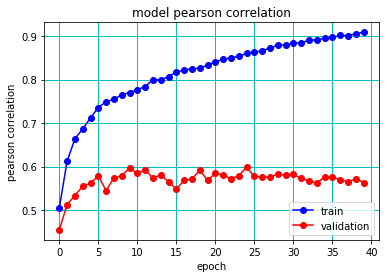

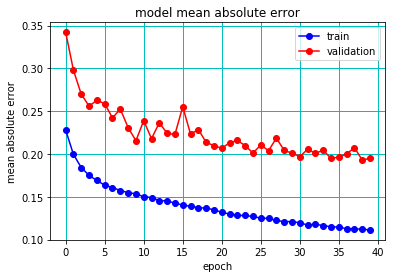

Model pearson correlation = 0.64
Model mean absolute error = 0.95

# Results for model 2: Embedding 50d > BiLSTM(256) > Dot

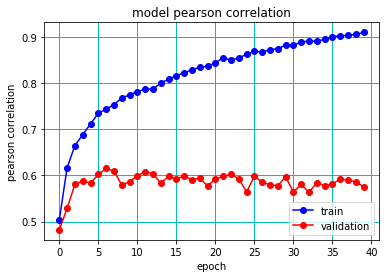

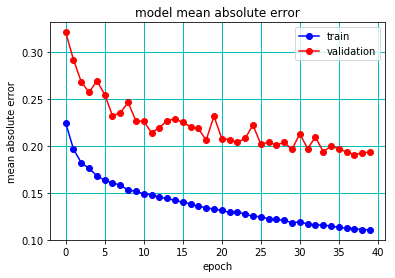

Test set results: 
Model pearson correlation = 0.65
Model mean absolute error = 1.0


# Results for model 3: Embedding 300d > BiLSTM(128) > Dot
    
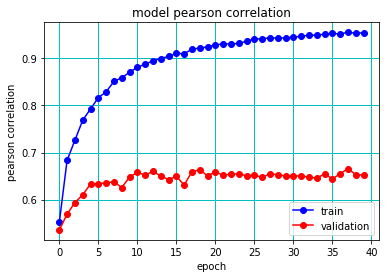

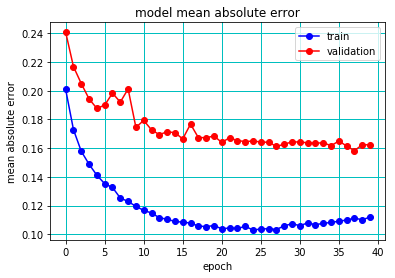

Test results : 
Model pearson correlation = 0.67
Model mean absolute error = 0.85


# Results for model 4: Embedding 300d > BiLSTM(128) > BiLSTM(128) > Dot

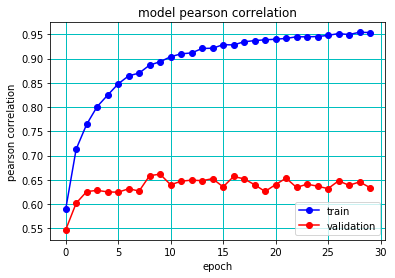

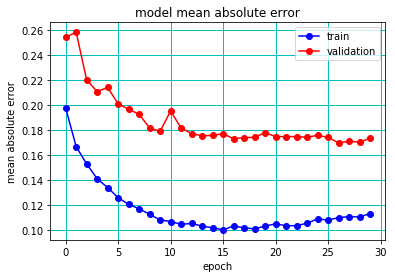

Model pearson correlation = 0.66
Model mean absolute error = 0.9

# Results for model 5: Embedding 300d > BiLSTM(265) > dot

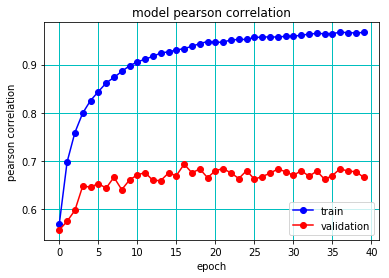


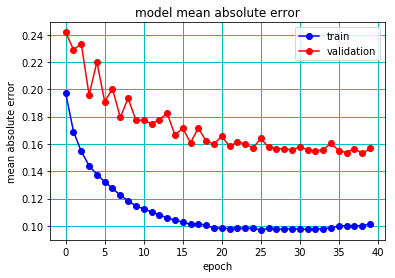

Test results: 
Model pearson correlation = 0.70
Model mean absolute error = 0.85

Random samples:

    Train Sample 2289 with similarity score 3.60 predicted score 3.93
    1 : We are all vessels filled with many wonders.
    2 : Put a Little Love in your Heart We are all vessels filled with many wonders.

    Validation Sample 1044 with similarity score 4.33 predicted score 4.17
    1 : His daughter, Nina Axelrod, told The Associated Press that he died in his sleep, apparently of heart failure.
    2 : Axelrod died in his sleep of heart failure, said his daughter, Nina Axelrod.

    Test Sample 106 with similarity score 0.00 predicted score 0.10
    1 : A man is playing guitar.
    2 : A boy is talking to a giant dog.

# Results for model 6: Embedding 300d > BiLSTM(600) > dot

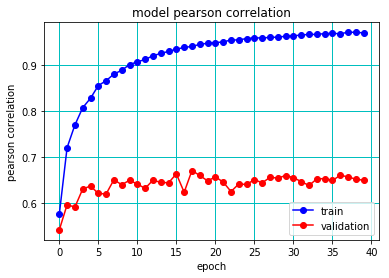

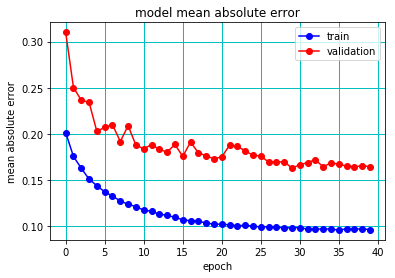

    Random samples: 

    Train Sample 399 with similarity score 3.50 predicted score 3.98
    1 : A person peels shrimp.
    2 : The lady peeled the shrimp.

    Validation Sample 1307 with similarity score 2.80 predicted score 3.23
    1 : Freight train derails, catches fire in Columbus, Ohio
    2 : Freight train derailment, explosion prompts evacuation

    Test Sample 1256 with similarity score 1.60 predicted score 2.58
    1 : Syria regime claims evacuation of 5,000 near Damascus
    2 : Syria army continues mop-up operations near Damascus
    
    Train Sample 3420 with similarity score 3.00 predicted score 2.97
    1 : Blair's government included the charge that Saddam sought uranium from Niger in a September 2002 dossier setting out the case for military action.
    2 : Britain included the accusation in a September 2002 dossier setting out the case for war in Iraq.

    Validation Sample 704 with similarity score 2.20 predicted score 1.84
    1 : In standard English, I think "don't got" has the same register as "ain't".
    2 : I'd say the expression I don't got... is generally rare in spoken AmE.

    Test Sample 1030 with similarity score 3.75 predicted score 4.18
    1 : Rich media doubled its share, increasing from 3% in Q2 2002 to 6% in Q2 2003.
    2 : Rich Media interactive ad formats doubled their share from 3% in second quarter of 2002, to 6% in the second quarter of 2003.


Test Results:
Model pearson correlation = 0.69
Model mean absolute error = 0.88


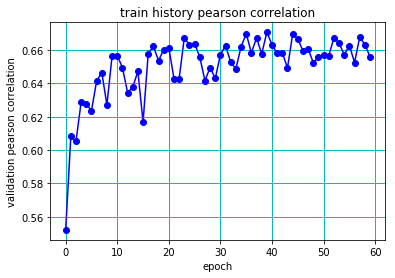

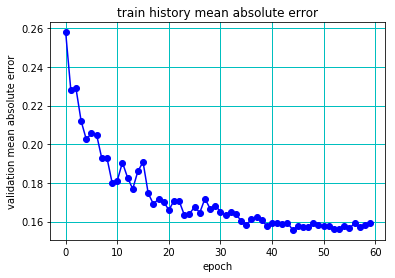

Best result around 40th epoch

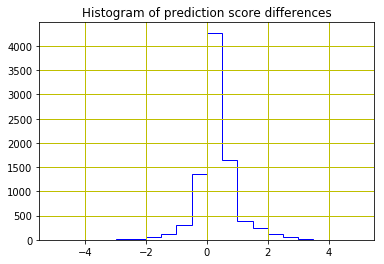

# Model summaries :

### Model 1

    LSTM_s = LSTM(256, name='LSTM_s')

    inp1 = Input(shape=(N_SEQ,), dtype='int32', name='Input1')
    x1 = Embedding(n_vocab, EMBED_DIM, weights=[keras_embedding_matrix], 
                    input_length=N_SEQ, trainable=False, name='Embedding1')(inp1)
    x1 = LSTM_s(x1)
    x1 = Dropout(0.2, name='Dropout1')(x1)

    inp2 = Input(shape=(N_SEQ,), dtype='int32', name='Input2')
    x2 = Embedding(n_vocab, EMBED_DIM, weights=[keras_embedding_matrix],
                   input_length=N_SEQ, trainable=False, name='Embedding2')(inp2)
    x2 = LSTM_s(x2)
    x2 = Dropout(0.2, name='Dropout2')(x2)

    d = keras.layers.Subtract(name='Subtract')([x1, x2])
    output = keras.layers.dot([x1, x2], axes=1, normalize=True, name='Dot')

    ____________________________________________________________________________________________________
    Layer (type)                     Output Shape          Param #     Connected to                     
    ====================================================================================================
    Input1 (InputLayer)              (None, 58)            0                                            
    ____________________________________________________________________________________________________
    Input2 (InputLayer)              (None, 58)            0                                            
    ____________________________________________________________________________________________________
    Embedding1 (Embedding)           (None, 58, 50)        767450      Input1[0][0]                     
    ____________________________________________________________________________________________________
    Embedding2 (Embedding)           (None, 58, 50)        767450      Input2[0][0]                     
    ____________________________________________________________________________________________________
    LSTM_s (LSTM)                    (None, 256)           314368      Embedding1[0][0]                 
                                                                       Embedding2[0][0]                 
    ____________________________________________________________________________________________________
    Dropout1 (Dropout)               (None, 256)           0           LSTM_s[0][0]                     
    ____________________________________________________________________________________________________
    Dropout2 (Dropout)               (None, 256)           0           LSTM_s[1][0]                     
    ____________________________________________________________________________________________________
    Dot (Dot)                        (None, 1)             0           Dropout1[0][0]                   
                                                                       Dropout2[0][0]                   
    ====================================================================================================
    Total params: 1,849,268
    Trainable params: 314,368
    Non-trainable params: 1,534,900
    ____________________________________________________________________________________________________

### Model 2

    BiLSTM_s = Bidirectional(LSTM(256),name='BiLSTM_s')

    inp1 = Input(shape=(N_SEQ,), dtype='int32', name='Input1')
    x1 = Embedding(n_vocab, EMBED_DIM, weights=[keras_embedding_matrix], 
                   input_length=N_SEQ, trainable=False, name='Embedding1')(inp1)
    x1 = BiLSTM_s(x1)
    x1 = Dropout(0.2, name='Dropout1')(x1)

    inp2 = Input(shape=(N_SEQ,), dtype='int32', name='Input2')
    x2 = Embedding(n_vocab, EMBED_DIM, weights=[keras_embedding_matrix],
                   input_length=N_SEQ, trainable=False, name='Embedding2')(inp2)
    x2 = BiLSTM_s(x2)
    x2 = Dropout(0.2, name='Dropout2')(x2)

    d = keras.layers.Subtract(name='Subtract')([x1, x2])
    output = keras.layers.dot([x1, x2], axes=1, normalize=True, name='Dot')

    ____________________________________________________________________________________________________
    Layer (type)                     Output Shape          Param #     Connected to                     
    ====================================================================================================
    Input1 (InputLayer)              (None, 58)            0                                            
    ____________________________________________________________________________________________________
    Input2 (InputLayer)              (None, 58)            0                                            
    ____________________________________________________________________________________________________
    Embedding1 (Embedding)           (None, 58, 50)        767450      Input1[0][0]                     
    ____________________________________________________________________________________________________
    Embedding2 (Embedding)           (None, 58, 50)        767450      Input2[0][0]                     
    ____________________________________________________________________________________________________
    BiLSTM_s (Bidirectional)         (None, 512)           628736      Embedding1[0][0]                 
                                                                       Embedding2[0][0]                 
    ____________________________________________________________________________________________________
    Dropout1 (Dropout)               (None, 512)           0           BiLSTM_s[0][0]                   
    ____________________________________________________________________________________________________
    Dropout2 (Dropout)               (None, 512)           0           BiLSTM_s[1][0]                   
    ____________________________________________________________________________________________________
    Dot (Dot)                        (None, 1)             0           Dropout1[0][0]                   
                                                                       Dropout2[0][0]                   
    ====================================================================================================
    Total params: 2,163,636
    Trainable params: 628,736
    Non-trainable params: 1,534,900
    ____________________________________________________________________________________________________

### Model 3

    BiLSTM_s = Bidirectional(LSTM(128),name='BiLSTM_s')

    inp1 = Input(shape=(N_SEQ,), dtype='int32', name='Input1')
    x1 = Embedding(n_vocab, EMBED_DIM, weights=[keras_embedding_matrix], 
                   input_length=N_SEQ, trainable=False, name='Embedding1')(inp1)
    x1 = BiLSTM_s(x1)
    x1 = Dropout(0.2, name='Dropout1')(x1)

    inp2 = Input(shape=(N_SEQ,), dtype='int32', name='Input2')
    x2 = Embedding(n_vocab, EMBED_DIM, weights=[keras_embedding_matrix], 
                   input_length=N_SEQ, trainable=False, name='Embedding2')(inp2)
    x2 = BiLSTM_s(x2)
    x2 = Dropout(0.2, name='Dropout2')(x2)

    d = keras.layers.Subtract(name='Subtract')([x1, x2])
    output = keras.layers.dot([x1, x2], axes=1, normalize=True, name='Dot')

    ____________________________________________________________________________________________________
    Layer (type)                     Output Shape          Param #     Connected to                     
    ====================================================================================================
    Input1 (InputLayer)              (None, 58)            0                                            
    ____________________________________________________________________________________________________
    Input2 (InputLayer)              (None, 58)            0                                            
    ____________________________________________________________________________________________________
    Embedding1 (Embedding)           (None, 58, 300)       4604700     Input1[0][0]                     
    ____________________________________________________________________________________________________
    Embedding2 (Embedding)           (None, 58, 300)       4604700     Input2[0][0]                     
    ____________________________________________________________________________________________________
    BiLSTM_s (Bidirectional)         (None, 256)           439296      Embedding1[0][0]                 
                                                                       Embedding2[0][0]                 
    ____________________________________________________________________________________________________
    Dropout1 (Dropout)               (None, 256)           0           BiLSTM_s[0][0]                   
    ____________________________________________________________________________________________________
    Dropout2 (Dropout)               (None, 256)           0           BiLSTM_s[1][0]                   
    ____________________________________________________________________________________________________
    Dot (Dot)                        (None, 1)             0           Dropout1[0][0]                   
                                                                       Dropout2[0][0]                   
    ====================================================================================================
    Total params: 9,648,696
    Trainable params: 439,296
    Non-trainable params: 9,209,400
    ____________________________________________________________________________________________________

### Model 4

    BiLSTM_s1 = Bidirectional(LSTM(128,return_sequences=True), name='BiLSTM_s1')
    BiLSTM_s2 = Bidirectional(LSTM(128),name='BiLSTM_s2')

    inp1 = Input(shape=(N_SEQ,), dtype='int32', name='Input1')
    x1 = Embedding(n_vocab, EMBED_DIM, weights=[keras_embedding_matrix], 
                   input_length=N_SEQ, trainable=False, name='Embedding1')(inp1)
    x1 = BiLSTM_s1(x1)
    x1 = BiLSTM_s2(x1)
    x1 = Dropout(0.2, name='Dropout1')(x1)

    inp2 = Input(shape=(N_SEQ,), dtype='int32', name='Input2')
    x2 = Embedding(n_vocab, EMBED_DIM, weights=[keras_embedding_matrix], 
                   input_length=N_SEQ, trainable=False, name='Embedding2')(inp2)
    x2 = BiLSTM_s1(x2)
    x2 = BiLSTM_s2(x2)
    x2 = Dropout(0.2, name='Dropout2')(x2)

    d = keras.layers.Subtract(name='Subtract')([x1, x2])
    output = keras.layers.dot([x1, x2], axes=1, normalize=True, name='Dot')
    
    Layer (type)                     Output Shape          Param #     Connected to                     
    ====================================================================================================
    Input1 (InputLayer)              (None, 58)            0                                            
    ____________________________________________________________________________________________________
    Input2 (InputLayer)              (None, 58)            0                                            
    ____________________________________________________________________________________________________
    Embedding1 (Embedding)           (None, 58, 300)       4604400     Input1[0][0]                     
    ____________________________________________________________________________________________________
    Embedding2 (Embedding)           (None, 58, 300)       4604400     Input2[0][0]                     
    ____________________________________________________________________________________________________
    BiLSTM_s1 (Bidirectional)        (None, 58, 256)       439296      Embedding1[0][0]                 
                                                                       Embedding2[0][0]                 
    ____________________________________________________________________________________________________
    BiLSTM_s2 (Bidirectional)        (None, 256)           394240      BiLSTM_s1[0][0]                  
                                                                       BiLSTM_s1[1][0]                  
    ____________________________________________________________________________________________________
    Dropout1 (Dropout)               (None, 256)           0           BiLSTM_s2[0][0]                  
    ____________________________________________________________________________________________________
    Dropout2 (Dropout)               (None, 256)           0           BiLSTM_s2[1][0]                  
    ____________________________________________________________________________________________________
    Dot (Dot)                        (None, 1)             0           Dropout1[0][0]                   
                                                                       Dropout2[0][0]                   
    ====================================================================================================
    Total params: 10,042,336
    Trainable params: 833,536
    Non-trainable params: 9,208,800
    ____________________________________________________________________________________________________
    
### Model 5

    BiLSTM_s = Bidirectional(LSTM(256),name='BiLSTM_s')

    inp1 = Input(shape=(N_SEQ,), dtype='int32', name='Input1')
    x1 = Embedding(n_vocab, EMBED_DIM, weights=[keras_embedding_matrix], 
                   input_length=N_SEQ, trainable=False, name='Embedding1')(inp1)
    x1 = BiLSTM_s(x1)
    x1 = Dropout(0.2, name='Dropout1')(x1)

    inp2 = Input(shape=(N_SEQ,), dtype='int32', name='Input2')
    x2 = Embedding(n_vocab, EMBED_DIM, weights=[keras_embedding_matrix], 
                   input_length=N_SEQ, trainable=False, name='Embedding2')(inp2)
    x2 = BiLSTM_s(x2)
    x2 = Dropout(0.2, name='Dropout2')(x2)

    d = keras.layers.Subtract(name='Subtract')([x1, x2])
    output = keras.layers.dot([x1, x2], axes=1, normalize=True, name='Dot')

    ____________________________________________________________________________________________________
    Layer (type)                     Output Shape          Param #     Connected to                     
    ====================================================================================================
    Input1 (InputLayer)              (None, 58)            0                                            
    ____________________________________________________________________________________________________
    Input2 (InputLayer)              (None, 58)            0                                            
    ____________________________________________________________________________________________________
    Embedding1 (Embedding)           (None, 58, 300)       4604700     Input1[0][0]                     
    ____________________________________________________________________________________________________
    Embedding2 (Embedding)           (None, 58, 300)       4604700     Input2[0][0]                     
    ____________________________________________________________________________________________________
    BiLSTM_s (Bidirectional)         (None, 512)           1140736     Embedding1[0][0]                 
                                                                       Embedding2[0][0]                 
    ____________________________________________________________________________________________________
    Dropout1 (Dropout)               (None, 512)           0           BiLSTM_s[0][0]                   
    ____________________________________________________________________________________________________
    Dropout2 (Dropout)               (None, 512)           0           BiLSTM_s[1][0]                   
    ____________________________________________________________________________________________________
    Dot (Dot)                        (None, 1)             0           Dropout1[0][0]                   
                                                                       Dropout2[0][0]                   
    ====================================================================================================
    Total params: 10,350,136
    Trainable params: 1,140,736
    Non-trainable params: 9,209,400
    ____________________________________________________________________________________________________
  



# Test with Microsoft downloaded sent2vec model

### Code

    # Format data for DSSM, CDSSM sent2vec

    f = open('pairs.txt', 'w', encoding='utf-8')
    for i in range(n_data):
        s = sent1_all[i]+'\t'+sent2_all[i]
        f.write(s)
    f.close()

    # set sent2vec=..\bin\sent2vec.exe
    # %sent2vec% /inSrcModel dssm_model\smodel /inSrcVocab dssm_model\vocab /inSrcModelType DSSM /inTgtModel dssm_model\tmodel /inTgtVocab dssm_model\vocab /inTgtModelType DSSM /inFilename pairs.txt /outFilenamePrefix dssm_out
    # %sent2vec% /inSrcModel cdssm_model\smodel /inSrcVocab cdssm_model\vocab /inSrcModelType CDSSM /inSrcMaxRetainedSeqLength 20 /inTgtModel cdssm_model\tmodel /inTgtVocab cdssm_model\vocab /inTgtModelType CDSSM /inTgtMaxRetainedSeqLength 20 /inFilename pairs.txt /outFilenamePrefix cdssm_out

    # Read microsoft DSSM, CDSSM model scores
    fdssm = open('dssm_out.score.txt', 'r', encoding='utf-8')
    fcdssm = open('cdssm_out.score.txt', 'r', encoding='utf-8')
    dssm_scores_all=[0.0] * n_data
    cdssm_scores_all=[0.0] * n_data
    i = 0
    while True:
        ldssm = fdssm.readline()  # read 1 line
        lcdssm = fcdssm.readline()  # read 1 line
        if not ldssm or not lcdssm:
            break
        dssm_scores_all[i] = float(ldssm) * 5.0
        cdssm_scores_all[i] = float(lcdssm) * 5.0
        i = i + 1

    fdssm.close()
    fcdssm.close()

    print(dssm_scores_all.shape, cdssm_scores_all.shape)
    
    dssm_err = np.subtract(scores_all, dssm_scores_all)
    cdssm_err = np.subtract(scores_all, cdssm_scores_all)

    dssm_mean_err = np.sum(dssm_err)/n_data
    cdssm_mean_err = np.sum(cdssm_err)/n_data

    dssm_mean_abserr = np.sum(np.abs(dssm_err))/n_data
    cdssm_mean_abserr = np.sum(np.abs(cdssm_err))/n_data

    dssm_pcorr = np.corrcoef(dssm_scores_all, scores_all)
    cdssm_pcorr = np.corrcoef(cdssm_scores_all, scores_all)

    print("Microsoft DSSM/CDSSM models pearson correlation, mean error and mean absolute error:")
    print("DSSM  : %.2f  %.2f  %.2f" % (dssm_pcorr[0][1], dssm_mean_err, dssm_mean_abserr))
    print("CDSSM : %.2f  %.2f  %.2f" % (cdssm_pcorr[0][1], cdssm_mean_err, cdssm_mean_abserr))

    plt.hist(dssm_err, bins=20, range=[-5.0, 5.0], histtype='step')
    plt.title('Histogram of DSSM prediction error')
    plt.show()

    plt.hist(cdssm_err, bins=20, range=[-5.0, 5.0], histtype='step')
    plt.title('Histogram of CDSSM prediction error')
    plt.show()



### Results

    Microsoft DSSM/CDSSM models pearson correlation, mean error and mean absolute error:
    DSSM  : 0.73  0.09  0.79
    CDSSM : 0.72  0.06  0.81

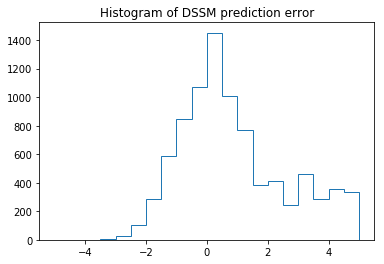

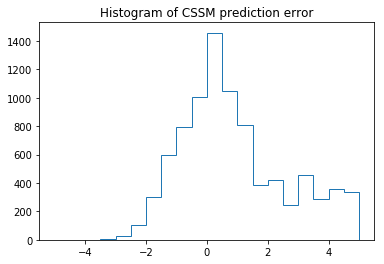

# Difference between nltk tokenizer and keras tokenizer:

## NLTK

    Total number of records    : 8628
    Total number of sentences  : 17256    
    Max words in one sentence  : 61                   # 3 words or 5% more
    Max char in one sentence   : 368
    Total number of words      : 197340               # 10% more
    Total number of vocabulary : 18511                # 20% more
    Total number of characters : 1028053

## Keras

    Total number of samples           n_data: 8628
    Total number of sentences         n_sent: 17256    
    Max words in one sentence  max_sent_wlen: 58
    Max char in one sentence   max_sent_clen: 368
    Total number of words            n_words: 178498
    Total number of vocabulary       n_vocab: 15348
    Total number of characters        n_char: 1010798